In [1]:
import matplotlib.pyplot as plt
import matplotlib
from forsims_stampede import SimHandler #this line is the code to use the simulations!
import datetime
from sys import getsizeof
import numpy as np
import galpy
import gala

from galpy.util import coords

import agama
import pandas as pd
import pickle
import os

# getting the data

In [2]:
sim = 'D2' #the name of the simulation that you want to look at
snapshot=500
simD2 = SimHandler(sim) #Make an instance (here we name the instance simM1) by calling the SimHandler class & 
simD2.recenter = False 

simD2.wdm == True #enabling dark matter

simD2.verbose==4

times = simD2.gettimes(return_array=True)


start init at: 2022-03-29 23:54:50.439477
end at: 2022-03-29 23:54:50.444576


In [3]:
print(times[:5],"......",times[-5:])

['snapshot__00001.0010-0', 'snapshot__00002.0000-0', 'snapshot__00003.0010-0', 'snapshot__00004.0009-0', 'snapshot__00005.0008-0'] ...... ['snapshot__00506.0007-0', 'snapshot__00507.0008-0', 'snapshot__00508.0008-0', 'snapshot__00509.0008-0', 'snapshot__00510.0009-0']


# Getting the simulation data 

In [4]:
%%time
full_snap, full_snap_dark= simD2.loadwholesnap(snapshot,forcedarkmatter=True)

CPU times: user 976 ms, sys: 1.32 s, total: 2.3 s
Wall time: 4.55 s


In [5]:
print(full_snap.dtype)

[('t', '<f8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('mass', '<f4'), ('idd', '<u8')]


In [ ]:
patternspped=computepatternspeed(self,start=None,finish=None)

# Downsampling the data

In [ ]:
%%time

simD2.downsamplefrac = 0.0005 #lets keep 0.05% of all particles. this is changing a class attribute!

full_snap = simD2.downsamplesnap(snaparr)
full_snap_dark = simD2.downsamplesnap(snaparr_dark)


# Storing downsampled data for future use

In [ ]:
downsampled_data={"snapshot":snapshot,"particle":full_snap,"dark_matter":full_snap_dark}
filename="downsampled_simdata_snapshot"+str(snapshot)+".pkl"
datapath="./data/"
if not os.path.exists(datapath):
  os.makedirs(datapath)

with open(datapath+filename, 'wb') as output:
      pickle.dump(downsampled_data, output)


In [36]:
# Checking the stored data
filename="downsampled_simdata_snapshot"+str(snapshot)+".pkl"
datapath="./data/"
with open(datapath+filename, "rb") as input:
      import_simdata = pickle.load(input)
        
print(import_simdata.keys())
print(import_simdata["particle"].dtype)
print("\n")
print(len(import_simdata["particle"]["mass"]),"particles in the downsample")
print(len(import_simdata["dark_matter"]["mass"]),"dark matter particles in the downsample")
print("\n")
print(np.min(import_simdata["particle"]["mass"]))
print(np.max(import_simdata["particle"]["mass"]))

dict_keys(['snapshot', 'particle', 'dark_matter'])
[('t', '<f8'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('mass', '<f4'), ('idd', '<u8')]


138039 particles in the downsample
501961 dark matter particles in the downsample


185.19353
482.0768


# Enable this if you are using the stored data

In [37]:
full_snap=import_simdata["particle"]
full_snap_dark=import_simdata["dark_matter"]

In [38]:
print('there are', len(full_snap), ' star particles in downsampled data!')
print('there are', len(full_snap_dark), ' dark matter particles in downsampled data!')

there are 138039  star particles in downsampled data!
there are 501961  dark matter particles in downsampled data!


In [6]:
idd=full_snap['idd']
x=full_snap['x']
y=full_snap['y']
z=full_snap['z']
vx=full_snap['vx']
vy=full_snap['vy']
vz=full_snap['vz']  
mass=full_snap['mass']  #mass is in solar mass (change old mass calculations to take account of the factor 2.324876e9)
print("Total Star Particles:",len(full_snap))
#del full_snap

iddd=full_snap_dark['idd']
xd=full_snap_dark['x']
yd=full_snap_dark['y']
zd=full_snap_dark['z']
vxd=full_snap_dark['vx']
vyd=full_snap_dark['vy']
vzd=full_snap_dark['vz']  
massd=full_snap_dark['mass']*2.324876e9
print("dark matter:",len(full_snap_dark))
#del full_snap_dark

Total Star Particles: 5996403
dark matter: 3337406


In [7]:
print(np.min(full_snap_dark['x']),np.max(full_snap_dark['x']))

-598.89185 5.9790683


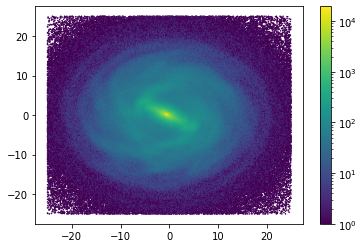

In [8]:
plt.hexbin(x,y,extent=((-25,25,-25,25)),gridsize=400,mincnt=1,bins="log")
plt.colorbar()

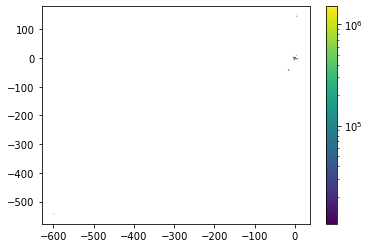

In [10]:
plt.hexbin(xd,yd,gridsize=400,mincnt=1,bins="log")
plt.colorbar()

# Getting rotation curve using regular method

In [25]:

#getting r for snaparr and snaparr_dark
#snaparr_r,snaparr_phi,snaparr_zz=coords.rect_to_cyl(x,y,z)
#snaparr_dark_r,snaparr_dark_phi,snaparr_dark_zz=coords.rect_to_cyl(xd,yd,zd)

r_sph_stars=np.sqrt(x**2+y**2+z**2)
r_sph_dark=np.sqrt(xd**2+yd**2+zd**2)

rmin=0.01
rmax=30
step_count=100
massflaglo=200
massflaghi=700
savepath="./"

radii = np.empty(step_count)
star_enc = np.empty(step_count)
total_enc = np.empty(step_count)
dark_enc = np.empty(step_count)


for ii,radius in enumerate(np.linspace(rmin, rmax, step_count)):
    #disk_annulus = (snaparr['r'] < radius) & (snaparr['mass']<massflaglo)
    #bulge_annulus = (snaparr['r'] < radius) & (snaparr['mass']>massflaglo) & (snaparr['mass']<massflaghi)
    #dark_annulus = (snaparr_dark['r'] < radius) & (snaparr_dark['mass']<massflaghi)

    star_annulus = np.where(r_sph_stars <= radius)
    dark_annulus = np.where(r_sph_dark <= radius)

    #mass enclosed
  
    star_enc[ii] = np.sum(mass[star_annulus])
    dark_enc[ii] = np.sum(massd[dark_annulus])
    total_enc[ii] = star_enc[ii]+dark_enc[ii]

    #radius
    radii[ii] = radius

G = 4.3 * 10**(-6) #kpc m_odot (km/s)^2

star_vc = np.sqrt((G * star_enc)/radii)
dark_vc = np.sqrt((G * dark_enc)/radii)
total_vc = np.sqrt((G * total_enc)/radii)

v_circ_df = pd.DataFrame(np.array([radii, star_vc, dark_vc, total_vc]).T, 
                    columns=['radius', 'star_vc', 'dark_vc', 'total_vc'])
#v_circ_df.to_csv(savepath+'downsampled_velocity_curve_timestep'+str(snapshot)+'.csv')

In [26]:
%%time
star_annulus = np.where(r_sph_stars <= 8)
print(star_annulus)

(array([  13125,   13129,   13132, ..., 5713565, 5713572, 5713575]),)
CPU times: user 28 ms, sys: 9.71 ms, total: 37.7 ms
Wall time: 27.6 ms


In [27]:
%%time
star_annulus_n = (r_sph_stars <= 8)
print(star_annulus_n)

[False False False ... False False False]
CPU times: user 6.5 ms, sys: 2.95 ms, total: 9.45 ms
Wall time: 5.65 ms


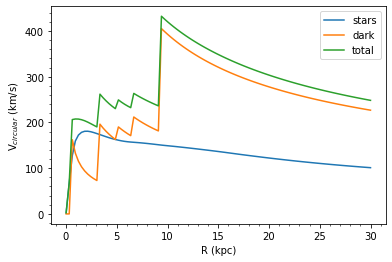

In [28]:
v_circ=v_circ_df
fig1=plt.figure()
ax1=fig1.add_subplot(111)
#ax1.plot(v_circ["radius"],v_circ["disk_vc"],label="disk")
#ax1.plot(v_circ["radius"],v_circ["bulge_vc"],label="bulge")
ax1.plot(v_circ["radius"],v_circ["star_vc"],label="stars")

ax1.plot(v_circ["radius"],v_circ["dark_vc"],label="dark")
ax1.plot(v_circ["radius"],v_circ["total_vc"],label="total")
ax1.legend()
ax1.set_xlabel("R (kpc)")
ax1.set_ylabel(r"V$_{circular}$ (km/s)")
ax1.minorticks_on()
#fig1.savefig("Rotation_Curves_downsampled_star_dark_total.jpg",dpi=200)

# Setting up agama

In [13]:
massflaglo=200
massflaghi=700



###############These were the cuts used in Jason's action finding code#########
#discindx=(mass<1e-7)   
#bulgeindx=(mass>1e-7)*(mass<1e-6)
################
#gets the actions for previous function and saves it
agama.setUnits(mass=1, length=1, velocity=1)
load = np.load
finder = agama.ActionFinder 
dm_mass   = massd  # mass needs to be in solar masses

halo_mass=mass
#disk_mass = mass[discindx]*2.324876e9   
#bulg_mass = mass[bulgeindx]*2.324876e9  # use this to convert in solar masses if not already there

#del mass,massd

In [14]:
print(np.max(mass))
print(np.min(mass))

482.0768
185.19353


In [17]:
halo_phasespace   = np.vstack((x,y,z,vx,vy,vz)).T
dm_phasespace   = np.vstack((xd,yd,zd,vxd,vyd,vzd)).T

#del x,y,z,vx,vy,vz
#del xd,yd,zd,vxd,vyd,vzd

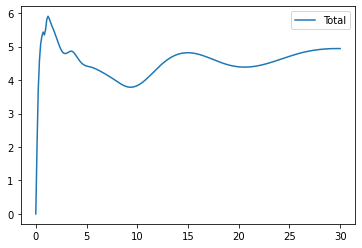

In [18]:
# create three components of a composite galaxy potential

dark = agama.Potential(type = "Multipole",particles=(dm_phasespace, dm_mass), symmetry='a', gridsizeR=20, lmax=2)

halo = agama.Potential(type = "Multipole",particles=(halo_phasespace, mass),symmetry='a',gridsizeR=20,lmax=2)    

potential = agama.Potential(dark,halo) #combining the potentials to get full potential

# choose the grid in radius to plot the profiles
r=np.linspace(0.0, 30.0, 250)
xyz=np.column_stack((r, r*0, r*0))
# circular velocity as a function of radius: total...
vcirc_total = np.sqrt(-r * potential.force(xyz)[:,0])

plt.plot(r, vcirc_total, label="Total")
plt.legend()
# ...and for each potential component separately

total_vc=vcirc_total
radii=r


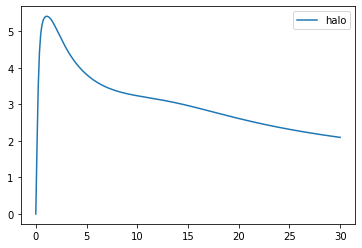

In [19]:
halo_vc=np.sqrt(-r * halo.force(xyz)[:,0])
plt.plot(r, halo_vc,label="halo")
plt.legend()

<ipython-input-21-e515acb526fa>:1: RuntimeWarning: invalid value encountered in sqrt
  dark_vc=np.sqrt(-r * dark.force(xyz)[:,0])



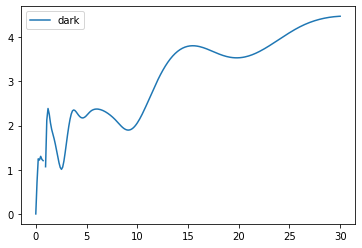

In [21]:
dark_vc=np.sqrt(-r * dark.force(xyz)[:,0])
plt.plot(r, dark_vc,label="dark")
plt.legend()

In [23]:
dark_vc=np.sqrt(-r * dark.force(xyz)[:,0])

'''
for p in potential:
    plt.plot(r, np.sqrt(-r * p.force(xyz)[:,0]),
    label=p.name() )
plt.legend(loc="lower right")
plt.show()
'''

v_circ_df_agama = pd.DataFrame(np.array([radii, halo_vc, dark_vc, total_vc]).T, 
                            columns=['radius','halo_vc', 'dark_vc', 'total_vc'])

v_circ_df_agama.to_csv("velocity_curve_star_dm_total"+str(snapshot)+"_agama.csv")

################
###############
#Code in their paper
'''
#pot_bulge = agama.Potential(type=’Sersic’, mass=1,scaleRadius=1, sersicIndex=4, axisRatioZ=0.6)
#pot_disc = agama.Potential(type=’Disk’, mass=4,scaleRadius=3, scaleHeight=0.5)
#pot_halo = agama.Potential(type=’NFW’, mass=25,scaleRadius=10)
#pot = agama.Potential(pot_bulge, pot_disc, pot_halo)

# represent the density profile as a collection of particles
snap = pot_bulge.sample(100000)
# create a potential from this N−body snapshot
pot_nbody = agama.Potential(type=’Multipole’, particles=snap, symmetry=’Axisymmetric’)
# choose the grid in radius to plot the profiles
r=numpy.linspace(0.0, 25.0, 250)
xyz=numpy.column_stack((r, r*0, r*0))
# circular velocity as a function of radius: total...
vcirc_total = numpy.sqrt(-r * pot.force(xyz)[:,0])
plt.plot(r, vcirc_total, label=’Total’)
# ...and for each potential component separately
for p in pot:
plt.plot(r, numpy.sqrt(-r * p.force(xyz)[:,0]),
label=p.name() )
plt.legend(loc=’lower right’)
plt.show()
'''

<ipython-input-23-62169e509d0a>:1: RuntimeWarning: invalid value encountered in sqrt
  dark_vc=np.sqrt(-r * dark.force(xyz)[:,0])



'\n#pot_bulge = agama.Potential(type=’Sersic’, mass=1,scaleRadius=1, sersicIndex=4, axisRatioZ=0.6)\n#pot_disc = agama.Potential(type=’Disk’, mass=4,scaleRadius=3, scaleHeight=0.5)\n#pot_halo = agama.Potential(type=’NFW’, mass=25,scaleRadius=10)\n#pot = agama.Potential(pot_bulge, pot_disc, pot_halo)\n\n# represent the density profile as a collection of particles\nsnap = pot_bulge.sample(100000)\n# create a potential from this N−body snapshot\npot_nbody = agama.Potential(type=’Multipole’, particles=snap, symmetry=’Axisymmetric’)\n# choose the grid in radius to plot the profiles\nr=numpy.linspace(0.0, 25.0, 250)\nxyz=numpy.column_stack((r, r*0, r*0))\n# circular velocity as a function of radius: total...\nvcirc_total = numpy.sqrt(-r * pot.force(xyz)[:,0])\nplt.plot(r, vcirc_total, label=’Total’)\n# ...and for each potential component separately\nfor p in pot:\nplt.plot(r, numpy.sqrt(-r * p.force(xyz)[:,0]),\nlabel=p.name() )\nplt.legend(loc=’lower right’)\nplt.show()\n'

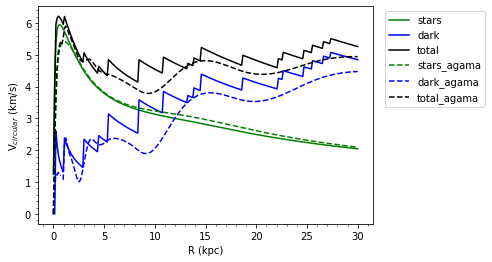

In [24]:
fig3=plt.figure()
ax1=fig3.add_subplot(111)

ax1.plot(v_circ["radius"],v_circ["halo_vc"],label="stars",c="green")
ax1.plot(v_circ["radius"],v_circ["dark_vc"],label="dark",c="blue")
ax1.plot(v_circ["radius"],v_circ["total_vc"],label="total",c="black")

ax1.plot(v_circ_df_agama["radius"],v_circ_df_agama["halo_vc"],label="stars_agama",c="green",linestyle="dashed")
ax1.plot(v_circ_df_agama["radius"],v_circ_df_agama["dark_vc"],label="dark_agama",c="blue",linestyle="dashed")
ax1.plot(v_circ_df_agama["radius"],v_circ_df_agama["total_vc"],label="total_agama",c="black",linestyle="dashed")
ax1.legend(loc="upper right",bbox_to_anchor=(1.35, 1))
ax1.set_xlabel("R (kpc)")
ax1.set_ylabel(r"V$_{circular}$ (km/s)")
ax1.minorticks_on()
fig3.savefig("Rotation_Curves_downsampled_agama_comparison_dark_star_total.jpg",dpi=200,bbox_inches="tight")